<a id='top'></a>

In [1]:
import warnings
warnings.filterwarnings('ignore')

# Predicting Nightly Mood Scores from Previously Submitted Mood, Daily Activity, and Sleep
Seeing if we can improve our predictive ability by including _all_ data (except for IAQ)

Some good information can be found [here](https://towardsdatascience.com/comprehensive-guide-to-multiclass-classification-with-sklearn-127cc500f362) on the general process.

In [2]:
import sys
sys.path.append('../')
%load_ext autoreload
%autoreload 2
from src.analysis import mood_prediction
from src.visualization import visualize

import pandas as pd
pd.set_option('display.max_columns', 200)
import numpy as np
from scipy import stats

from datetime import datetime, timedelta

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import seaborn as sns
import matplotlib.dates as mdates

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression

# Table of Contents
1. [Data Import](#data_import)
2. [Inspection](#inspection)
3. [Modeling](#modeling)
4. [Evaluation](#evaluation)

---

<a id='data_import'></a>

# Data Import
We use the `ImportProcessing` to get the relevant data.

In [4]:
data = mood_prediction.ImportProcessing(data_dir="../data/")
data.mood_and_activity = data.remove_participant(data.mood_and_activity,"oxcpr7e3")
data.mood_and_activity.head()

Column timestamp not in DataFrame
Column timestamp not in DataFrame
Column timestamp_e not in DataFrame
Column timestamp_m not in DataFrame


,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,steps,distance,discontent_m,discontent_e
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,4722.0,1.853799,2.0,1.0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,4199.0,1.720204,1.0,1.0
6,qh34m4r9,3.0,1.0,0.0,0.0,4.0,68,2020-05-13,3.0,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,11632.0,5.302906,0.0,0.0
8,tmexej5v,2.0,1.0,1.0,0.0,3.0,42,2020-05-13,2.0,1.0,1.0,0.0,3.0,6.0,15.0,0.0,2.0,521.0,0.202008,1.0,1.0
9,vpy1a985,2.0,1.0,2.0,1.0,2.0,50,2020-05-13,2.0,1.0,2.0,1.0,2.0,7.0,10.0,1.0,2.0,553.0,0.237737,1.0,1.0


---

<a id='inspection'></a>

# Inspection
Doing some higher-level inspection of the data.

---

<a id='modeling'></a>

# Modeling

In [5]:
modeling = mood_prediction.Model()

## Adding Features
We add the `step_goal` feature which determine whether or not the participant was able to reach the 10K (default) step goal.

In [6]:
data.mood_and_activity = modeling.binarize_steps(data.mood_and_activity)
data.mood_and_activity.head()

,beiwe,content_e,stress_e,lonely_e,sad_e,energy_e,redcap,date,content_m,stress_m,lonely_m,sad_m,energy_m,tst,sol,naw,restful,steps,distance,discontent_m,discontent_e,step_goal
2,rvhdl2la,2.0,1.0,0.0,0.0,1.0,29,2020-05-13,1.0,1.0,2.0,3.0,0.0,5.3,5.0,2.0,2.0,4722.0,1.853799,2.0,1.0,0
4,xdbdrk6e,2.0,1.0,2.0,1.0,3.0,23,2020-05-13,2.0,1.0,2.0,1.0,2.0,8.0,20.0,3.0,2.0,4199.0,1.720204,1.0,1.0,0
6,qh34m4r9,3.0,1.0,0.0,0.0,4.0,68,2020-05-13,3.0,0.0,0.0,0.0,1.0,8.0,20.0,2.0,3.0,11632.0,5.302906,0.0,0.0,1
8,tmexej5v,2.0,1.0,1.0,0.0,3.0,42,2020-05-13,2.0,1.0,1.0,0.0,3.0,6.0,15.0,0.0,2.0,521.0,0.202008,1.0,1.0,0
9,vpy1a985,2.0,1.0,2.0,1.0,2.0,50,2020-05-13,2.0,1.0,2.0,1.0,2.0,7.0,10.0,1.0,2.0,553.0,0.237737,1.0,1.0,0


## BIinarizing Datasets

In [7]:
data_bi = modeling.binarize_mood(data.mood_and_activity)
data_bi_targets = modeling.binarize_mood(data.mood_and_activity,binarize_features=False)

### Class Ratios
Checking to see which the ratio of classes

In [8]:
for df in [data.mood_and_activity,data_bi_targets]:
    for mood in ["discontent","stress","sad","lonely","energy"]:
        print(f"\t{mood.title()}")
        for val in sorted(df[f"{mood}_e"].unique()):
            n = len(df[df[f"{mood}_e"] == val])
            print(f"\t\t{val}:\t{n}\tRatio:\t{n/len(df[f'{mood}_e'])}")

	Discontent
		0.0:	393	Ratio:	0.3275
		1.0:	495	Ratio:	0.4125
		2.0:	265	Ratio:	0.22083333333333333
		3.0:	35	Ratio:	0.029166666666666667
		nan:	0	Ratio:	0.0
	Stress
		0.0:	494	Ratio:	0.4116666666666667
		1.0:	467	Ratio:	0.38916666666666666
		2.0:	162	Ratio:	0.135
		3.0:	61	Ratio:	0.050833333333333335
		nan:	0	Ratio:	0.0
	Sad
		0.0:	820	Ratio:	0.6833333333333333
		1.0:	286	Ratio:	0.23833333333333334
		2.0:	57	Ratio:	0.0475
		3.0:	24	Ratio:	0.02
		nan:	0	Ratio:	0.0
	Lonely
		0.0:	779	Ratio:	0.6491666666666667
		1.0:	259	Ratio:	0.21583333333333332
		2.0:	129	Ratio:	0.1075
		3.0:	20	Ratio:	0.016666666666666666
		nan:	0	Ratio:	0.0
	Energy
		0.0:	91	Ratio:	0.07583333333333334
		1.0:	216	Ratio:	0.18
		2.0:	535	Ratio:	0.44583333333333336
		3.0:	253	Ratio:	0.21083333333333334
		4.0:	93	Ratio:	0.0775
		nan:	0	Ratio:	0.0
	Discontent
		0:	393	Ratio:	0.3275
		1:	807	Ratio:	0.6725
	Stress
		0:	494	Ratio:	0.4116666666666667
		1:	706	Ratio:	0.5883333333333334
	Sad
		0:	820	Ratio:	0.6833333333333333
	

## Tuning Models
We know we plan to use the `GradientBoostClassifier` so we just have to consider the hyperparameters of this model type. We define an extensive amount just to be sure! We also want to include a `LogisticRegression` classifier as a base case to compare against.

In [9]:
modeling.set_model_params({
        "gradientboost":{
            "model": GradientBoostingClassifier(random_state=42),
            "params": {
                "n_estimators":[5,10,20,50],
                "max_depth":[2],
                "min_samples_split":[2,3,],
                "min_samples_leaf":[1,2,3],
            }
        },
        "logistic_regression": {
            "model":LogisticRegression(random_state=42,max_iter=500),
            "params": {
                "fit_intercept":[True,False],
                "solver":["lbfgs","liblinear"],
            }
        },
    })

### Grid Search
Using our favorite, we examine the scores for using these models using 5-fold cross-validation

#### Multi-Class Classification

In [10]:
opt_res = modeling.optimize_models(data.mood_and_activity,modeling.model_params,additional_features=["steps","tst","sol","restful","naw"])

	Gradientboost
		Elapsed Time:	 0:00:10.025576
		Best Score:	66.4
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Logistic Regression
		Elapsed Time:	 0:00:02.106469
		Best Score:	60.4
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:10.645030
		Best Score:	67.4
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20}
	Logistic Regression
		Elapsed Time:	 0:00:02.112482
		Best Score:	61.8
		Best Params:	{'fit_intercept': False, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:10.427037
		Best Score:	79.0
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 20}
	Logistic Regression
		Elapsed Time:	 0:00:02.081671
		Best Score:	73.7
		Best Params:	{'fit_intercept': False, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:10.356553
		Best Score:	78.1
		Best Params:	{'max_depth': 2, 'mi

In [11]:
opt_res

,mood,model,best_score,best_params
0,content,gradientboost,66.377830,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
1,content,logistic_regression,60.445464,"{'fit_intercept': True, 'solver': 'liblinear'}"
2,stress,gradientboost,67.389163,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
3,stress,logistic_regression,61.778997,"{'fit_intercept': False, 'solver': 'liblinear'}"
4,lonely,gradientboost,79.001036,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
5,lonely,logistic_regression,73.665828,"{'fit_intercept': False, 'solver': 'liblinear'}"
6,sad,gradientboost,78.141187,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s..."
7,sad,logistic_regression,75.129865,"{'fit_intercept': True, 'solver': 'liblinear'}"
8,energy,gradientboost,56.185807,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s..."
9,energy,logistic_regression,50.344088,"{'fit_intercept': True, 'solver': 'liblinear'}"


<div class="alert alert-block alert-success">
    
We will consider the following hyperparameters for the `GradientBoostClassifier`:
* `max_depth=2`
* `min_samples_leaf=2`
* `n_estimators=20`
    
</div>

In [12]:
tuned_models = {"grad":GradientBoostingClassifier(random_state=42,n_estimators=20,max_depth=2,min_samples_leaf=2,min_samples_split=2),
               "lr":LogisticRegression(random_state=42,max_iter=500,fit_intercept=True,solver="liblinear")}
modeling.set_tuned_models(tuned_models)

#### Binary Classsification
We conduct two binary classification models to understand the effect of binarizing the mood features:
1. **Binary Targets Only**: Only the targets are binary, not the features
2. **Binary Everything**: Name says it all

In [13]:
opt_res_binary = modeling.optimize_models(data_bi_targets,modeling.model_params,additional_features=["steps","tst","sol","restful","naw"])

	Gradientboost
		Elapsed Time:	 0:00:02.337238
		Best Score:	81.9
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
	Logistic Regression
		Elapsed Time:	 0:00:00.383719
		Best Score:	80.7
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:02.251980
		Best Score:	81.4
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
	Logistic Regression
		Elapsed Time:	 0:00:00.469935
		Best Score:	80.9
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:02.269644
		Best Score:	86.0
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 5}
	Logistic Regression
		Elapsed Time:	 0:00:00.713744
		Best Score:	85.4
		Best Params:	{'fit_intercept': True, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:02.356668
		Best Score:	81.9
		Best Params:	{'max_depth': 2, 'min_samples_le

In [14]:
opt_res_binary

,mood,model,best_score,best_params
0,content,gradientboost,81.872340,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
1,content,logistic_regression,80.680851,"{'fit_intercept': True, 'solver': 'lbfgs'}"
2,stress,gradientboost,81.361702,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
3,stress,logistic_regression,80.936170,"{'fit_intercept': True, 'solver': 'liblinear'}"
4,lonely,gradientboost,85.957447,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
5,lonely,logistic_regression,85.446809,"{'fit_intercept': True, 'solver': 'lbfgs'}"
6,sad,gradientboost,81.872340,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
7,sad,logistic_regression,81.021277,"{'fit_intercept': True, 'solver': 'lbfgs'}"
8,energy,gradientboost,78.297872,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
9,energy,logistic_regression,78.297872,"{'fit_intercept': False, 'solver': 'lbfgs'}"


<div class="alert alert-block alert-success">
    
We will consider the following hyperparameters for the `GradientBoostClassifier`:
* `max_depth=2`
* `min_samples_leaf=1`
* `n_estimators=20`
    
</div>

In [15]:
opt_res_binary_2 = modeling.optimize_models(data_bi,modeling.model_params,additional_features=["steps","tst","sol","restful","naw"])

	Gradientboost
		Elapsed Time:	 0:00:02.135599
		Best Score:	81.3
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 50}
	Logistic Regression
		Elapsed Time:	 0:00:00.393891
		Best Score:	81.2
		Best Params:	{'fit_intercept': True, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:02.142536
		Best Score:	81.2
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Logistic Regression
		Elapsed Time:	 0:00:00.415572
		Best Score:	81.2
		Best Params:	{'fit_intercept': False, 'solver': 'liblinear'}
	Gradientboost
		Elapsed Time:	 0:00:02.124784
		Best Score:	85.8
		Best Params:	{'max_depth': 2, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 10}
	Logistic Regression
		Elapsed Time:	 0:00:00.527625
		Best Score:	85.7
		Best Params:	{'fit_intercept': False, 'solver': 'lbfgs'}
	Gradientboost
		Elapsed Time:	 0:00:02.479499
		Best Score:	82.0
		Best Params:	{'max_depth': 2, 'min_sa

In [16]:
opt_res_binary_2

,mood,model,best_score,best_params
0,content,gradientboost,81.279651,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
1,content,logistic_regression,81.194908,"{'fit_intercept': True, 'solver': 'liblinear'}"
2,stress,gradientboost,81.194199,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
3,stress,logistic_regression,81.194554,"{'fit_intercept': False, 'solver': 'liblinear'}"
4,lonely,gradientboost,85.833067,"{'max_depth': 2, 'min_samples_leaf': 1, 'min_s..."
5,lonely,logistic_regression,85.749034,"{'fit_intercept': False, 'solver': 'lbfgs'}"
6,sad,gradientboost,82.038436,"{'max_depth': 2, 'min_samples_leaf': 2, 'min_s..."
7,sad,logistic_regression,81.616849,"{'fit_intercept': True, 'solver': 'liblinear'}"
8,energy,gradientboost,77.569762,"{'max_depth': 2, 'min_samples_leaf': 3, 'min_s..."
9,energy,logistic_regression,77.233982,"{'fit_intercept': False, 'solver': 'liblinear'}"


<div class="alert alert-block alert-success">
    
We will consider the following hyperparameters for the `GradientBoostClassifier`:
* `max_depth=2`
* `min_samples_leaf=1`
* `n_estimators=50`
    
</div>

In [17]:
tuned_models_bi = {"grad":GradientBoostingClassifier(random_state=42,n_estimators=20,max_depth=2,min_samples_leaf=2,min_samples_split=2),
                  "lr":LogisticRegression(random_state=42,max_iter=500,fit_intercept=True,solver="lbfgs")}
modeling.set_tuned_models_bi(tuned_models_bi)

## Cross-Validation
We will use three different techniques of cross-validation to compare and understand the sensitivity of our models to different sets of the data:
1. **Stratified K-Fold**: This method will ensure that the same ratio of the target classes are preserved which is important especially considering we have four classes in this instance compared to our binary evaluations in the past.
2. **Group K-Fold**: This method will help test the sensitivity to any particular participant groups.

### Stratified K-Fold

#### Multiclass

In [18]:
res_skf_mc = modeling.cross_validate(data.mood_and_activity,tuned_models,cv_label="skf",additional_features=["steps","tst","sol","restful","naw"])
res_skf_mc

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.678112,0.630901,0.708155,0.620690,0.633621,0.654296
1,content,lr,0.600858,0.579399,0.652361,0.599138,0.590517,0.604455
2,stress,grad,0.689655,0.637931,0.672414,0.650862,0.714286,0.673030
3,stress,lr,0.612069,0.612069,0.650862,0.577586,0.632035,0.616924
4,lonely,grad,0.811159,0.772532,0.754310,0.797414,0.806034,0.788290
5,lonely,lr,0.742489,0.716738,0.724138,0.750000,0.732759,0.733225
6,sad,grad,0.793991,0.781116,0.737069,0.797414,0.788793,0.779677
7,sad,lr,0.751073,0.742489,0.758621,0.780172,0.724138,0.751299
8,energy,grad,0.579399,0.557940,0.575107,0.532189,0.564655,0.561858
9,energy,lr,0.519313,0.502146,0.502146,0.484979,0.508621,0.503441


#### Binary Targets

In [19]:
res_skf_bt = modeling.cross_validate(data_bi_targets,tuned_models,cv_label="skf",additional_features=["steps","tst","sol","restful","naw"])
res_skf_bt

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.821277,0.770213,0.838298,0.812766,0.838298,0.816170
1,content,lr,0.821277,0.761702,0.812766,0.791489,0.834043,0.804255
2,stress,grad,0.855319,0.778723,0.817021,0.782979,0.834043,0.813617
3,stress,lr,0.842553,0.778723,0.821277,0.782979,0.821277,0.809362
4,lonely,grad,0.880851,0.851064,0.846809,0.855319,0.863830,0.859574
5,lonely,lr,0.868085,0.834043,0.846809,0.855319,0.863830,0.853617
6,sad,grad,0.851064,0.800000,0.765957,0.842553,0.834043,0.818723
7,sad,lr,0.838298,0.778723,0.765957,0.851064,0.804255,0.807660
8,energy,grad,0.770213,0.774468,0.800000,0.795745,0.774468,0.782979
9,energy,lr,0.774468,0.770213,0.787234,0.808511,0.753191,0.778723


#### Binary Everything

In [20]:
res_skf_bi = modeling.cross_validate(data_bi,tuned_models,cv_label="skf",additional_features=["steps","tst","sol","restful","naw"])
res_skf_bi

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.823529,0.767932,0.835443,0.801688,0.805907,0.806900
1,content,lr,0.840336,0.780591,0.831224,0.793249,0.814346,0.811949
2,stress,grad,0.848739,0.784810,0.814346,0.780591,0.831224,0.811942
3,stress,lr,0.844538,0.780591,0.814346,0.789030,0.827004,0.811102
4,lonely,grad,0.878151,0.852321,0.843882,0.860759,0.856540,0.858331
5,lonely,lr,0.865546,0.852321,0.843882,0.860759,0.856540,0.855810
6,sad,grad,0.844538,0.793249,0.767932,0.848101,0.831224,0.817009
7,sad,lr,0.840336,0.793249,0.772152,0.835443,0.839662,0.816168
8,energy,grad,0.789916,0.751055,0.780591,0.784810,0.746835,0.770641
9,energy,lr,0.777311,0.746835,0.801688,0.759494,0.759494,0.768964


<div class="alert alert-block alert-success">
    
Models tend to be rather consistent amongst the various splits
    
</div>

### Group K-Fold

#### Multiclass

In [21]:
res_gkf_mc = modeling.cross_validate(data.mood_and_activity,tuned_models,cv_label="gkf",additional_features=["steps","tst","sol","restful","naw"])
res_gkf_mc

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.603448,0.660944,0.699571,0.599138,0.643777,0.641376
1,content,lr,0.543103,0.510730,0.622318,0.495690,0.626609,0.559690
2,stress,grad,0.630901,0.646552,0.692641,0.724138,0.597403,0.658327
3,stress,lr,0.506438,0.581897,0.632035,0.693966,0.610390,0.604945
4,lonely,grad,0.711207,0.845494,0.775862,0.823276,0.716738,0.774515
5,lonely,lr,0.629310,0.845494,0.681034,0.762931,0.630901,0.709934
6,sad,grad,0.663793,0.849785,0.818966,0.746781,0.810345,0.777934
7,sad,lr,0.663793,0.832618,0.827586,0.699571,0.706897,0.746093
8,energy,grad,0.559829,0.579399,0.616379,0.532189,0.439655,0.545490
9,energy,lr,0.478632,0.472103,0.431034,0.454936,0.452586,0.457858


#### Binary Targets

In [22]:
res_gkf_bt = modeling.cross_validate(data_bi_targets,tuned_models,cv_label="gkf",additional_features=["steps","tst","sol","restful","naw"])
res_gkf_bt

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.834746,0.824786,0.762712,0.761702,0.816239,0.800037
1,content,lr,0.788136,0.837607,0.720339,0.761702,0.837607,0.789078
2,stress,grad,0.805085,0.794872,0.830508,0.897872,0.739316,0.813531
3,stress,lr,0.796610,0.777778,0.830508,0.893617,0.739316,0.807566
4,lonely,grad,0.800847,0.914530,0.843220,0.851064,0.888889,0.859710
5,lonely,lr,0.805085,0.918803,0.838983,0.846809,0.880342,0.858004
6,sad,grad,0.737288,0.884615,0.737288,0.876596,0.871795,0.821516
7,sad,lr,0.716102,0.884615,0.724576,0.885106,0.858974,0.813875
8,energy,grad,0.622881,0.850427,0.766949,0.859574,0.760684,0.772103
9,energy,lr,0.656780,0.850427,0.771186,0.863830,0.739316,0.776308


In [23]:
res_gkf_bi = modeling.cross_validate(data_bi,tuned_models,cv_label="gkf",additional_features=["steps","tst","sol","restful","naw"])
res_gkf_bi

,mood,model,split_1,split_2,split_3,split_4,split_5,mean
0,content,grad,0.801688,0.848739,0.771186,0.764706,0.780591,0.793382
1,content,lr,0.818565,0.836134,0.771186,0.768908,0.780591,0.795077
2,stress,grad,0.839662,0.831933,0.822034,0.773109,0.776371,0.808622
3,stress,lr,0.835443,0.831933,0.830508,0.777311,0.767932,0.808626
4,lonely,grad,0.784810,0.936975,0.813559,0.882353,0.852321,0.854004
5,lonely,lr,0.780591,0.932773,0.826271,0.878151,0.852321,0.854021
6,sad,grad,0.717300,0.936975,0.779661,0.815126,0.848101,0.819433
7,sad,lr,0.679325,0.924370,0.771186,0.819328,0.843882,0.807618
8,energy,grad,0.729958,0.836134,0.796610,0.781513,0.717300,0.772303
9,energy,lr,0.734177,0.815126,0.758475,0.760504,0.751055,0.763867


<div class="alert alert-block alert-success">
    
Similar results to the stratified split both in terms of variation and average scores.
    
</div>

[Back to Modeling](#modeling)

---

<a id='prediction'></a>

# Prediction
Since our models seemed to pass the test with the cross-validation, now we can use them to predict the outcomes. 

In [24]:
predictor = mood_prediction.Prediction()

In [25]:
y_true, y_pred = predictor.get_predictions(data_bi,mood="content",model=modeling.tuned_models["grad"],include_evening=False,additional_features=["steps","tst","sol","restful","naw"])

---

<a id='evaluation'></a>

# Evaluation
[Here](https://towardsdatascience.com/comprehensive-guide-on-multiclass-classification-metrics-af94cfb83fbd) is a nice article regarding various metrics to consider for multiclass classification.

[Here](https://towardsdatascience.com/understanding-classification-metrics-6b585a6377de) is another that is more general regarding classification.

In [26]:
evaluator = mood_prediction.Evaluation()

## Confusion Matrices
We can look at how well our models perform by considering the confusion matrices.

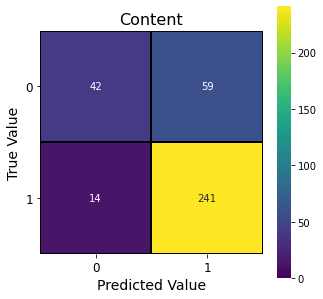

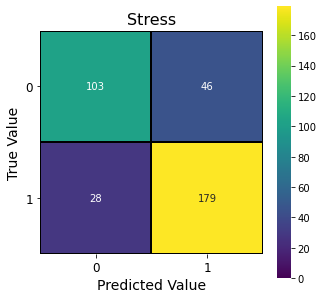

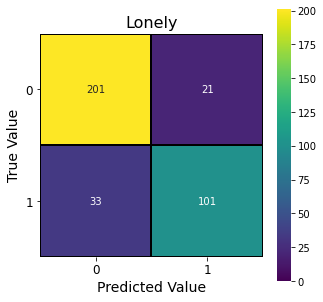

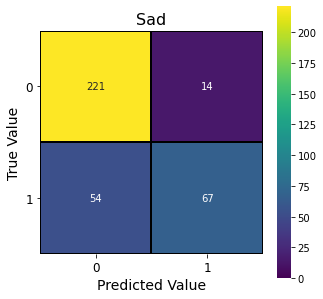

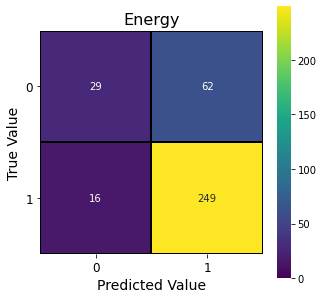

In [27]:
for mood in ["content","stress","lonely","sad","energy"]:
    y_true, y_pred = predictor.get_predictions(data_bi,mood,tuned_models["grad"],include_evening=True,additional_features=["steps","tst","sol","restful","naw"])
    _ = evaluator.get_cm(y_true, y_pred, plot=True,title=mood.title())

## All the metrics
Who knew there was a fancy function for all this? In addition, we borrow some advice from the TDS crew.

This [post](https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1) has a nice review of why we were originally getting `accuracy=recall`.

### Multiclass

In [28]:
scores_multi = evaluator.get_scoring_metrics(data.mood_and_activity,tuned_models["lr"],include_evening=False,additional_features=["steps","tst","sol","restful","naw"])

In [29]:
print(scores_multi.round(decimals=2).set_index("mood").to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &  recall &    f1 \\
mood       &           &            &         &       \\
\midrule
Discontent &      0.44 &       0.59 &    0.60 &  0.59 \\
Stress     &      0.43 &       0.59 &    0.62 &  0.58 \\
Lonely     &      0.41 &       0.69 &    0.73 &  0.70 \\
Sad        &      0.34 &       0.68 &    0.75 &  0.71 \\
Energy     &      0.33 &       0.45 &    0.50 &  0.40 \\
\bottomrule
\end{tabular}



### Binary

In [30]:
scores_bi = evaluator.get_scoring_metrics(data_bi_targets,tuned_models["grad"],binary=True,include_evening=False,additional_features=["steps","tst","sol","restful","naw"])

In [31]:
print(scores_bi.round(decimals=3).set_index("mood").to_latex())

\begin{tabular}{lrrrr}
\toprule
{} &  accuracy &  precision &  recall &     f1 \\
mood       &           &            &         &        \\
\midrule
Discontent &     0.793 &      0.847 &   0.937 &  0.890 \\
Stress     &     0.799 &      0.821 &   0.879 &  0.848 \\
Lonely     &     0.836 &      0.831 &   0.756 &  0.791 \\
Sad        &     0.775 &      0.751 &   0.653 &  0.697 \\
Energy     &     0.617 &      0.793 &   0.958 &  0.868 \\
\bottomrule
\end{tabular}



In [32]:
#evaluator.get_scoring_metrics(data_bi,tuned_models["grad"],binary=True,include_evening=False,additional_features=["steps","tst","sol","restful","naw"])

## Feature Importances

### Multiclass

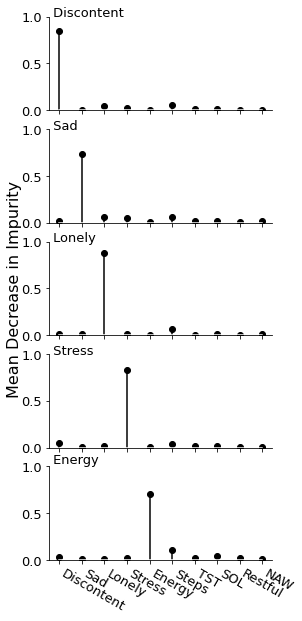

In [49]:
res = evaluator.get_feature_importances(data.mood_and_activity,tuned_models["grad"],
                                  features=["discontent_m","sad_m","lonely_m","stress_m","energy_m","steps","tst","sol","restful","naw"],save=False)

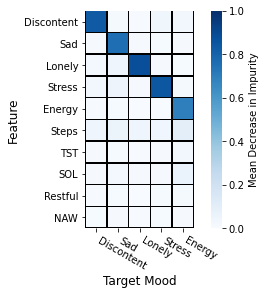

In [50]:
fig, ax = plt.subplots()
df_to_plot = res.set_index("mood")
sns.heatmap(df_to_plot.T,square=True,cmap="Blues",vmin=0,vmax=1,lw=0.5,linecolor="black",
            cbar_kws={"label":"Mean Decrease in Impurity"},
            ax=ax)
# x-axis
xlabels = []
for mood in df_to_plot.index:
    xlabels.append(mood.title())
ax.set_xticklabels(xlabels,fontsize=10,rotation=-30,ha="left")
ax.set_xlabel("Target Mood",fontsize=12)
# y-axis
ylabels = []
for col in df_to_plot.columns:
    ylabels.append(visualize.get_label(col))
ax.set_yticklabels(ylabels,fontsize=10)
ax.set_ylabel("Feature",fontsize=12)
# remainder

plt.savefig("../reports/figures/ema_fitbit/feature_importance-mood_sleep_activity_on_mood-heatmap-ux_s20.pdf",bbox_inches="tight")
plt.show()
plt.close()

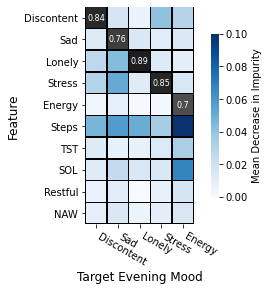

In [73]:
fig, ax = plt.subplots()
df_to_plot = res.set_index("mood")
df = df_to_plot.copy()
for row in df.index:
    for col in df.columns:
        if row[:3] == col[:3]:
            df.loc[row,col] = np.nan
#df = df.div(df.sum(axis=1), axis=0)
df.fillna(-10,inplace=True)
sns.heatmap(df.T,square=True,cmap="Blues",vmin=0,vmax=0.1,lw=0.5,linecolor="black",
            cbar_kws={"label":"Mean Decrease in Impurity","shrink":0.75},
            ax=ax)
sns.heatmap(df_to_plot.T, mask=df_to_plot.T < 0.6, cbar=False,lw=0.5,linecolor="black",
            annot=True, annot_kws={"fontsize":8},cmap="binary",vmin=0,vmax=1,
           ax=ax)
# x-axis
ylabels = []
for mood in df.index:
    ylabels.append(mood.title())
ax.set_xticklabels(ylabels,fontsize=10,rotation=-30,ha="left")
ax.set_xlabel("Target Evening Mood",fontsize=12)
# y-axis
xlabels = []
for col in df.columns:
    xlabels.append(visualize.get_label(col))
ax.set_yticklabels(xlabels,fontsize=10)
ax.set_ylabel("Feature",fontsize=12)
# remainder

plt.savefig("../reports/figures/ema_fitbit/feature_importance_multi-mood_sleep_activity_on_mood_scaled-heatmap-ux_s20.pdf",bbox_inches="tight")
plt.show()
plt.close()

## Binary

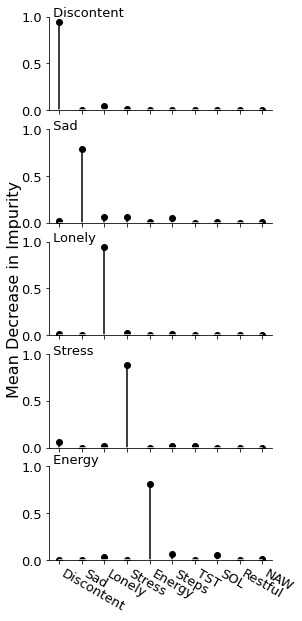

In [46]:
res_bi = evaluator.get_feature_importances(data_bi_targets,tuned_models["grad"],
                                  features=["discontent_m","sad_m","lonely_m","stress_m","energy_m","steps","tst","sol","restful","naw"],save=False)

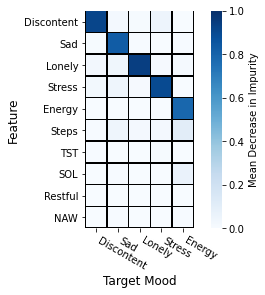

In [47]:
fig, ax = plt.subplots()
df_to_plot = res_bi.set_index("mood")
sns.heatmap(df_to_plot.T,square=True,cmap="Blues",vmin=0,vmax=1,lw=0.5,linecolor="black",
            cbar_kws={"label":"Mean Decrease in Impurity"},
            ax=ax)
# x-axis
xlabels = []
for mood in df_to_plot.index:
    xlabels.append(mood.title())
ax.set_xticklabels(xlabels,fontsize=10,rotation=-30,ha="left")
ax.set_xlabel("Target Mood",fontsize=12)
# y-axis
ylabels = []
for col in df_to_plot.columns:
    ylabels.append(visualize.get_label(col))
ax.set_yticklabels(ylabels,fontsize=10)
ax.set_ylabel("Feature",fontsize=12)
# remainder

#plt.savefig("../reports/figures/ema_fitbit/feature_importance-mood_sleep_activity_on_mood-heatmap-ux_s20.pdf",bbox_inches="tight")
plt.show()
plt.close()

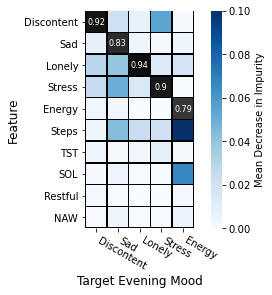

In [48]:
fig, ax = plt.subplots()
df_to_plot = res_bi.set_index("mood")
df = df_to_plot.copy()
for row in df.index:
    for col in df.columns:
        if row[:3] == col[:3]:
            df.loc[row,col] = np.nan
#df = df.div(df.sum(axis=1), axis=0)
df.fillna(-10,inplace=True)
sns.heatmap(df.T,square=True,cmap="Blues",vmin=0,vmax=0.1,lw=0.5,linecolor="black",
            cbar_kws={"label":"Mean Decrease in Impurity"},
            ax=ax)
sns.heatmap(df_to_plot.T, mask=df_to_plot.T < 0.7, cbar=False,lw=0.5,linecolor="black",
            annot=True, annot_kws={"fontsize":8},cmap="binary",vmin=0,vmax=1,
           ax=ax)
# x-axis
xlabels = []
for mood in df.index:
    xlabels.append(mood.title())
ax.set_xticklabels(xlabels,fontsize=10,rotation=-30,ha="left")
ax.set_xlabel("Target Evening Mood",fontsize=12)
# y-axis
ylabels = []
for col in df.columns:
    ylabels.append(visualize.get_label(col))
ax.set_yticklabels(ylabels,fontsize=10)
ax.set_ylabel("Feature",fontsize=12)
# remainder

plt.savefig("../reports/figures/ema_fitbit/feature_importance-mood_sleep_activity_on_mood_scaled-heatmap-ux_s20.pdf",bbox_inches="tight")
plt.show()
plt.close()

[Back to Evaluation](#evaluation)

---

# Saving

## Results

In [39]:
with pd.ExcelWriter('../data/interim/mood_prediction/results-mood_and_activity_on_mood.xlsx') as writer:  
    for model,model_bi in zip(modeling.tuned_models.keys(),modeling.tuned_models_bi.keys()):
        for include_evening in [False,True]:
            print(f"{model.upper()} - Include Evening: {include_evening}")
            print("\tMulticlass")
            res = evaluator.get_scoring_metrics(data.mood_and_activity,modeling.tuned_models[model],include_evening=include_evening,additional_features=["step_goal"])
            res.to_excel(writer, sheet_name=f"{model}-multiclass-evening_{str(include_evening).lower()}")
            print("\tBinary")
            res_bi = evaluator.get_scoring_metrics(data_bi,modeling.tuned_models_bi[model_bi],binary=True,include_evening=include_evening,additional_features=["step_goal"])
            res_bi.to_excel(writer, sheet_name=f"{model}-binary-evening_{str(include_evening).lower()}")

GRAD - Include Evening: False
	Multiclass
	Binary
GRAD - Include Evening: True
	Multiclass
	Binary
LR - Include Evening: False
	Multiclass
	Binary
LR - Include Evening: True
	Multiclass
	Binary


[Back to Top](#top)